# Usando autoencoders para aprender bailes

El challenge de hoy está basado en un kernel de kaggle que muestra un posible uso de los autoencoders combinados con las RNN (Leed el post que os hemos dejado en la preparación de este challenge). El enlace al kernel original lo tendréis al final de este cuaderno, con la intención de que lo uséis una vez hayáis acabado para comprobar que todo ha funcionado como se quería.

Ya que pasarle frame a frame a una RNN puede ser muy bruto, vamos a obtener una representación más eficiente de cada frame (efectivamente, aquí entran los autoencoders). La idea es por lo tanto crear dos redes, una primera que nos permita comprimir cada frame en un vector eficiente y una segunda a la que se le pasen una serie de secuencias y sea capaz de producir la siguiente. ¿Listos? ¡Vamos a ello!

## Paso 1

Para empezar vamos a preprocesar el video. Una vez tengamos el video descargado, habrá que cargarlo y separarlo frame a frame. Para ello vamos a necesitar varias librerías, principalmente: numpy, pandas y matplotlib para el funcionamiento estandar, opencv(cv2) para leer el video y PIL y skimage para tratar los frames.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop #, pad       note: pad is from numpy
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb

import os

Aquí os recomiendo crear un directorio `data` para ir dejando las imágenes, es más cómodo, y de paso inicializar algunos valores que vamos a necesitar, principalmente ancho y alto de la imágen, en cuantos canales nos va a venir y el período con el que nos saltamos frames (si están demasiado cerca el cambio será mínimo y la red predicirá el siguiente frame como una copia del ultimo que le hemos pasado).

In [3]:
%mkdir -p "data"

In [4]:
data_folder = 'data'
save_to_local = True

In [5]:
# Crear directorio e inicializar variables
# inits counters
currentFrame, count = 0, 0

TRAIN_SIZE, FRAME_SKIP = 10000, 2

# img size the same as past exercises
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 64, 96, 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH)

X_train = np.zeros((TRAIN_SIZE,)+(IMG_HEIGHT, IMG_WIDTH)+(1,))

LATENT_SPACE_SIZE = 128

# opencv
# VideoCapture is class that captures video files or img secuences
# VideoCapture.get() returns a property from the instance
# CAP_PROP_FPS is the frame rate from the VideoCapture instance

cap = cv2.VideoCapture('/content/drive/MyDrive/satAI/week_04/challenge/data/DanceMoves.mp4')
print(cap.get(cv2.CAP_PROP_FPS))

# the DanceMoves video has arround 30fps (frames per second)
# therefore, 15fps means that 6k secs

29.97002997002997


In [6]:
X_train.shape

(10000, 64, 96, 1)

Con estos parámetros ya definidos, el siguiente paso es empezar a pasar el video frame a frame y guardar cada uno de ellos. En este caso y ya que lo que nos interesan son las siluetas, en el preprocesamiento de cada frame vamos a pasar cada imágen a blanco y negro (paso a grises y luego paso a blanco/negro). De esta manera las imágenes tendrán solo dos valores en cada píxel y tendrán solo un canal. Si queréis cambiar esto, simplemente no hagáis este trozo de código e indicad que el número de canales es otro.

In [7]:
# crear el conjunto de entrenamiento del autoencoder

while(count < TRAIN_SIZE):
    try:

        # read() method returns retval, imag and
        # its function is to grab, decode and return the
        # next video frame
        # --  a read() needs a close() 
        # could it be done > with cap.read(): ...
        ret, frame = cap.read()

        if currentFrame % FRAME_SKIP == 0:
            # reducir de escala, reducir a un canal y pasar a B/N 
            # resize() for reducing the size of the imge
            # arg dsize = (h, w, nchannels) -> 64, 96, 1
            # fx and fy allow for ratio distortion
            frame = cv2.resize(
                src=frame,
                dsize=(IMG_WIDTH, IMG_HEIGHT)  # AL CONTRARIO AQUI
            )
            # cvtColor method to change channels
            # using the colors space that changes RGB to GREYSCALE
            frame = cv2.cvtColor(
                src=frame,
                code=cv2.COLOR_BGR2GRAY,
                dstCn=1
            )
            frame= np.reshape(frame, newshape=frame.shape+(1,))
            # Guardar la imágen en el directorio que habíamos creado
            # cv2.imwrite() is a method that returns retval
            if save_to_local:
              cv2.imwrite(
                  filename=f"/content/{data_folder}/frame_{currentFrame}.jpg",
                  img=frame
              )

            # Grabar directamente en un dataset 
            X_train[count] = frame /255 # In order to normalize tensor at loss

            count += 1
            if count % (TRAIN_SIZE/10) == 0:
                print(f'Processing frame {count} of {TRAIN_SIZE}')

    except Exception as e:
        print(e)
        break


    currentFrame += 1
    
print('Fin del proceso de extracción de frames')
# como todo buffer, toca cerrar
cap.release()

Processing frame 1000 of 10000
Processing frame 2000 of 10000
Processing frame 3000 of 10000
Processing frame 4000 of 10000
Processing frame 5000 of 10000
Processing frame 6000 of 10000
Processing frame 7000 of 10000
Processing frame 8000 of 10000
Processing frame 9000 of 10000
Processing frame 10000 of 10000
Fin del proceso de extracción de frames


In [9]:
def display(array1, array2, dim):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10
    plt.figure(figsize=(20, 4))

    for i in range(n):
      
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(array1[i].reshape(dim))
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(array2[i].reshape(dim))
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [10]:
X_validation = X_train[9000:]
X_train = X_train[:9000]

X_train.shape, X_validation.shape

((9000, 64, 96, 1), (1000, 64, 96, 1))

In [11]:
X_train.shape

(9000, 64, 96, 1)

## Parte 2 - Autoencoder

Ya tenemos generado el conjunto de datos con el que vamos a trabajar, así que ahora toca diseñar el modelo. Os dejo los imports ya hechos para que tengáis una idea de por donde empezar. Recordad que hemos definido antes el tamaño que iba a tener el espacio latente, y que este tamaño debe ser la salida del modelo del encoder y del decoder. Si, vamos a definirlos por separado. Lo vamos a hacer así para, tras entrenar el transformer entero, solo tengamos que copiar pesos a esta estructura ya definida.

In [25]:
# imports de modelo y capas que queráis usar, nosotros os dejamos estas

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, UpSampling2D, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.backend import int_shape
from tensorflow.keras.optimizers import Adam

In [13]:
input_shape=INPUT_SHAPE+(1,)
input_shape

(64, 96, 1)

In [14]:
# Definir el encoder, ya sabeis que el tamaño de salida debe coincidir con la entrada del decoder

def Encoder(input_shape, latent_shape):
    """ Encoder model. Creates an instance of keras.Model()
    which tekaes inputs and feature, being feature a RNN
    """
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Convolutional layer
    # each layer reduces img by strides or pool_size
    # in this case (2,2) > 96,64 > 48, 32 
    
    model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu',padding = 'same'))
    model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same'))
    
    model.add(MaxPooling2D((2, 2), padding='same'))  
    
    model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same'))
    model.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu',padding = 'same'))
    
    model.add(Flatten()) 
    model.add(Dense(latent_shape, activation='sigmoid'))
    
    return model

###########################
encoder = Encoder(input_shape=INPUT_SHAPE+(1,), latent_shape=LATENT_SPACE_SIZE)
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 96, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 96, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 48, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 48, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                        

In [15]:
# Definir el edecoder, ya sabeis que el tamaño de entrada debe coincidir con la salida del encoder

# Decoder model. Creates an instance of keras.Model() which takes inputs and feature. 
# The architecture has to be simmetric to the Encoder.
def Decoder(input_shape, latent_shape):
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(Dense(latent_shape, activation='relu'))
    model.add(Dense(32*48*16, activation='relu'))
    model.add(Reshape((32, 48, 16))) # 2x4x16 = 128

    model.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu',padding = 'same'))
    model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same'))
    
    model.add(UpSampling2D((2, 2)))  
    
    model.add(Conv2DTranspose(filters = 32, kernel_size = 3, activation = 'relu',padding = 'same'))
    model.add(Conv2DTranspose(filters = 64, kernel_size = 3, activation = 'relu',padding = 'same'))
    
    # para que la salida tenga 1 canal y no 64, añado la capa con funcion de activación sigmoide
    model.add(Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same"))

    #model.add(UpSampling2D((2, 2)))  
        
    return model

# el output tiene que ser (None, 64, 96, 1)

###########################
decoder = Decoder(input_shape=encoder.output_shape[1:], latent_shape=LATENT_SPACE_SIZE)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 24576)             3170304   
                                                                 
 reshape (Reshape)           (None, 32, 48, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 48, 16)        2320      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 48, 32)        4640      
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 96, 32)       0         
 )                                                               
                                                      

In [28]:
# finalmente el autoencoder no será otra cosa que la estructura del encoder capa por capa y justo a continuación la del decoder capa por capa
def Autoencoder(input_shape, latent_shape):
    """ Instancia las funciones de Encoder y Decoder
    """
    
    model = Sequential()
    model.add(Input(shape=input_shape ))
    model.add(Encoder(
        input_shape=input_shape, 
        latent_shape=latent_shape)
    )
    
    x = model.output_shape[1:]
    model.add(Decoder(input_shape=x,
                     latent_shape=LATENT_SPACE_SIZE))
    
    return model


##########################

model = Autoencoder(
    input_shape=INPUT_SHAPE+(1,),
    latent_shape=LATENT_SPACE_SIZE
)

model.compile(
    optimizer=Adam(lr = 0.001), 
    loss=['binary_crossentropy', 'mse']
)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 128)               3178832   
                                                                 
 sequential_13 (Sequential)  (None, 64, 96, 1)         3222097   
                                                                 
Total params: 6,400,929
Trainable params: 6,400,929
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
input_shape

(64, 96, 1)

In [20]:
# A callback is an object that can perform actions at various stages 
# of training. 

# You can pass a list of instances of callbacks (as the keyword 
# argument callbacks) to the .fit() method of a model.

# - EarlyStopping: https://keras.io/api/callbacks/early_stopping/
# - ModelCheckpoint: https://keras.io/api/callbacks/model_checkpoint/
# - ReduceLROnPlateau: https://keras.io/api/callbacks/reduce_lr_on_plateau/

# Ref: https://keras.io/api/callbacks/

model_callbacks = [
    EarlyStopping(monitor="loss", patience=3, verbose = 1), 
    # ModelCheckpoint(),
    ReduceLROnPlateau(monitor="loss", factor=0.1, patience = 3, min_lr=0.0001)
]

In [29]:
# - EarlyStopping: https://keras.io/api/callbacks/early_stopping/
# - ModelCheckpoint: https://keras.io/api/callbacks/model_checkpoint/
# - ReduceLROnPlateau: https://keras.io/api/callbacks/reduce_lr_on_plateau/

#VALIDATION_SPLIT = 0.2
EPOCHS = 40
BATCH_SIZE = 64

history = model.fit(
    x=X_train, 
    y=X_train,
    epochs= EPOCHS,
    #validation_split = VALIDATION_SPLIT,
    callbacks=model_callbacks,
    batch_size= BATCH_SIZE
)

Epoch 1/40
141/141 [==============================] - 10s 64ms/step - loss: 0.6137 - lr: 0.0010
Epoch 2/40
141/141 [==============================] - 9s 64ms/step - loss: 0.5739 - lr: 0.0010
Epoch 3/40
141/141 [==============================] - 9s 64ms/step - loss: 0.5639 - lr: 0.0010
Epoch 4/40
141/141 [==============================] - 9s 64ms/step - loss: 0.5588 - lr: 0.0010
Epoch 5/40
141/141 [==============================] - 9s 65ms/step - loss: 0.5551 - lr: 0.0010
Epoch 6/40
141/141 [==============================] - 9s 65ms/step - loss: 0.5525 - lr: 0.0010
Epoch 7/40
141/141 [==============================] - 9s 65ms/step - loss: 0.5506 - lr: 0.0010
Epoch 8/40
141/141 [==============================] - 9s 65ms/step - loss: 0.5495 - lr: 0.0010
Epoch 9/40
141/141 [==============================] - 9s 65ms/step - loss: 0.5480 - lr: 0.0010
Epoch 10/40
141/141 [==============================] - 9s 65ms/step - loss: 0.5469 - lr: 0.0010
Epoch 11/40
141/141 [===========================

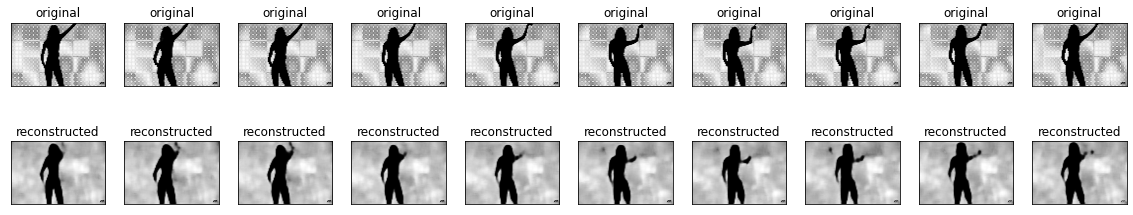

In [30]:
X_pred  = model.predict(X_validation[100:110])

display(X_validation[100:110], X_pred, (64,96))

## Una de guardar los rasultados y tal, ¿no?

In [31]:
model.save('Dancer_Auto_Model.hdf5')
model.save_weights("Dancer_Auto_Weights.hdf5")

Ahora que tenemos guardados tanto el modelo como los pesos que se han aprendido, podemos cargarlos en los modelos Encoder y Decoder que hemos creado antes (¿Cómodo eh?)

In [33]:
encoder = Encoder(    
    input_shape=INPUT_SHAPE+(1,),
    latent_shape=LATENT_SPACE_SIZE
)
decoder = Decoder(
    input_shape=encoder.output_shape[1:],
    latent_shape=LATENT_SPACE_SIZE
)

# Cargar los pesos correspondientes desde el autoencoder por nombre
encoder.load_weights("Dancer_Auto_Weights.hdf5", by_name=True)
decoder.load_weights("Dancer_Auto_Weights.hdf5", by_name=True)

# Guardar Modelo
decoder.save('Dancer_Decoder_Model.hdf5') 
encoder.save('Dancer_Encoder_Model.hdf5')

# Guardar pesos
decoder.save_weights("Dancer_Decoder_Weights.hdf5")
encoder.save_weights("Dancer_Encoder_Weights.hdf5")

In [34]:
Dance_Data  = encoder.predict(X_train) # y con esto tenemos ya la base para entrenar la RNN

## Parte 3 - Crear el conjunto de entrenamiento para la RNN

A la red que prediga el siguiente frame le tendremos que pasar una secuencia de unos ciertos frames para que, en función de estos, prediga el siguiente. Esto va a tener forma de una estructura de datos donde cada "rodaja" será una matriz donde estarán apilados los vectores que representan cada frame de la secuencia base. Por lo tanto, las etiquetas a predecir será una matriz con los vectores correspondientes a cada secuencia a predecir. Esto no es por si de la lección de este sábado, pero os lo dejo hecho para que no tengais que pegaros con ello y estéis más tiempo en el autoencoder ;). Si os veis pegados, os puedo pasar tambien los pesos de la red, que ya entrené y guardé en su momento.

In [35]:
X_train.shape

(9000, 64, 96, 1)

In [36]:
TRAIN_SIZE = Dance_Data.shape[0]
INPUT_SIZE = Dance_Data.shape[1]
SEQUENCE_LENGTH = 70

X_train = np.zeros((TRAIN_SIZE-SEQUENCE_LENGTH, SEQUENCE_LENGTH, INPUT_SIZE), dtype='float32')
Y_train = np.zeros((TRAIN_SIZE-SEQUENCE_LENGTH, INPUT_SIZE), dtype='float32')

for i in range(0, TRAIN_SIZE-SEQUENCE_LENGTH, 1 ): 
    X_train[i] = Dance_Data[i:i + SEQUENCE_LENGTH]
    Y_train[i] = Dance_Data[i + SEQUENCE_LENGTH]

print(X_train.shape)
print(Y_train.shape)

(8930, 70, 128)
(8930, 128)


Con el conjunto de entrenamiento creado, lo único que queda es definir la red que va a aprender de él:

In [37]:
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.utils import np_utils

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

def RNN_Dance():
    inp = Input(shape=(SEQUENCE_LENGTH, INPUT_SIZE))
    x = LSTM(512, return_sequences=True,)(inp)
    x = LSTM(256, return_sequences=True,)(x)
    x = LSTM(512, return_sequences=True,)(x)
    x = LSTM(256, return_sequences=True,)(x)
    x = LSTM(512, return_sequences=True,)(x)
    x = LSTM(1024,)(x)
    x = Dense(512, activation="elu")(x)
    x = Dense(256, activation="elu")(x)
    outp = Dense(INPUT_SIZE, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='mse',
                  optimizer=Adam(lr=0.0002),
                  metrics=['accuracy'])
    return model
  
model = RNN_Dance()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 70, 128)]         0         
                                                                 
 lstm (LSTM)                 (None, 70, 512)           1312768   
                                                                 
 lstm_1 (LSTM)               (None, 70, 256)           787456    
                                                                 
 lstm_2 (LSTM)               (None, 70, 512)           1574912   
                                                                 
 lstm_3 (LSTM)               (None, 70, 256)           787456    
                                                                 
 lstm_4 (LSTM)               (None, 70, 512)           1574912   
                                                                 
 lstm_5 (LSTM)               (None, 1024)              629555

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### A entrenar!!

In [38]:
last_callbacks = [
    EarlyStopping(monitor="accuracy", patience=5)]

model.fit(X_train, Y_train,
              batch_size=64,
              epochs=60,
              callbacks=last_callbacks,
              verbose=1)

Epoch 1/60
140/140 [==============================] - 24s 115ms/step - loss: 0.0141 - accuracy: 0.5811
Epoch 2/60
140/140 [==============================] - 16s 116ms/step - loss: 3.2721e-04 - accuracy: 0.7281
Epoch 3/60
140/140 [==============================] - 16s 117ms/step - loss: 3.1210e-04 - accuracy: 0.7281
Epoch 4/60
140/140 [==============================] - 17s 118ms/step - loss: 2.4720e-04 - accuracy: 0.6878
Epoch 5/60
140/140 [==============================] - 17s 119ms/step - loss: 2.4398e-04 - accuracy: 0.7281
Epoch 6/60
140/140 [==============================] - 17s 120ms/step - loss: 2.4473e-04 - accuracy: 0.7184
Epoch 7/60
140/140 [==============================] - 17s 121ms/step - loss: 2.4447e-04 - accuracy: 0.7180


In [39]:
%mkdir -p "models"

In [40]:
model.save("models/Ai_Dance_RNN_Model.hdf5")
model.save_weights('models/Ai_Dance_RNN_Weights.hdf5')

Una vez entrenado, generaremos unos cuantos vectores. Es interesante añadirle de vez en cuando un frame aleatorio para que no se quede parado en un bucle

In [41]:
DANCE_LENGTH  = 6000
LOOPBREAKER = 10

x = np.random.randint(0, X_train.shape[0]-1)
pattern = X_train[x]
outp = np.zeros((DANCE_LENGTH, INPUT_SIZE), dtype='float32')
for t in range(DANCE_LENGTH):
    x = np.reshape(pattern, (1, pattern.shape[0], pattern.shape[1]))
    pred = model.predict(x)
    result = pred[0]
    outp[t] = result
    new_pattern = np.zeros((SEQUENCE_LENGTH, INPUT_SIZE), dtype='float32') 
    new_pattern[0:SEQUENCE_LENGTH-1] = pattern[1:SEQUENCE_LENGTH]
    new_pattern[-1] = result
    pattern = np.copy(new_pattern)
    ####loopbreaker####
    if t % LOOPBREAKER == 0:
        pattern[np.random.randint(0, SEQUENCE_LENGTH-10)] = Y_train[np.random.randint(0, Y_train.shape[0]-1)]
    
    if t % 100 == 0:
        print(f"Processed {t} frames.")

Processed 0 frames.
Processed 100 frames.
Processed 200 frames.
Processed 300 frames.
Processed 400 frames.
Processed 500 frames.
Processed 600 frames.
Processed 700 frames.
Processed 800 frames.
Processed 900 frames.
Processed 1000 frames.
Processed 1100 frames.
Processed 1200 frames.
Processed 1300 frames.
Processed 1400 frames.
Processed 1500 frames.
Processed 1600 frames.
Processed 1700 frames.
Processed 1800 frames.
Processed 1900 frames.
Processed 2000 frames.
Processed 2100 frames.
Processed 2200 frames.
Processed 2300 frames.
Processed 2400 frames.
Processed 2500 frames.
Processed 2600 frames.
Processed 2700 frames.
Processed 2800 frames.
Processed 2900 frames.
Processed 3000 frames.
Processed 3100 frames.
Processed 3200 frames.
Processed 3300 frames.
Processed 3400 frames.
Processed 3500 frames.
Processed 3600 frames.
Processed 3700 frames.
Processed 3800 frames.
Processed 3900 frames.
Processed 4000 frames.
Processed 4100 frames.
Processed 4200 frames.
Processed 4300 frames.


Ahora simplemente generamos el video decodificando los vectores para recuperar las imágenes

In [42]:
Dance_Output = decoder.predict(outp)

video = cv2.VideoWriter('models/AI_Dance_Video.avi', cv2.VideoWriter_fourcc(*"XVID"), 20.0, (IMG_WIDTH, IMG_HEIGHT),False)

for img in Dance_Output:
    img = resize(img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
    img = img * 255
    img = img.astype('uint8')
    video.write(img)
    cv2.waitKey(50)
    
video.release()

Y nos guardamos los pesos por si acaso ;)

In [43]:
# Guardar Modelo
decoder.save('models/Dancer_Decoder_Model.hdf5') 
encoder.save('models/Dancer_Encoder_Model.hdf5')

# Guardar pesos
decoder.save_weights("models/Dancer_Decoder_Weights.hdf5")
encoder.save_weights("models/Dancer_Encoder_Weights.hdf5")


model.save("models/Ai_Dance_RNN_Model.hdf5")
model.save_weights('models/Ai_Dance_RNN_Weights.hdf5')